# Analysis of thermistor calibration

In [1]:
import sys
import math
sys.path.append('../')

# Steinhar Hart equation, coefficients and temperature prediction
from SteinhartHart import SteinHart

# Calculating with static + systematic errors
from formulas import Physical_Unit
from physical_units import *

import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd
import numpy as np 

## 1. Retrieve the data

3 distinct measurements were performed.

We will fetch the data and store it in [dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

In [26]:
df_cold = pd.read_csv('../data/rev_csv_2018-11-27_10-35.csv')
df_hot = pd.read_csv('../data/rev_csv_2018-11-27_11-02.csv')[:180]
df_avg = pd.read_csv('../data/rev_csv_2018-11-20_11-18.csv')[15:]

df = df_cold
df = df.append(df_hot, ignore_index=True)
df = df.append(df_avg, ignore_index=True)
df.tail(2)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
317,58,43918.644068,25.78690,25.78690,-0.321965,0.045522,-0.000132,25.78690,43918.644068,27.6842,41900.552486,29.59512,40764.0
318,59,43918.644068,25.75397,25.75397,-0.314063,0.044407,-0.000129,25.75397,43918.644068,27.6842,41900.552486,29.59512,40764.0


In [29]:
df_char_datasheet = pd.read_csv('../data/B57621C473J62-ND _char.csv').set
df_char_datasheet.head()

,T,RT/R25
0,0.0,3.2063
1,5.0,2.5019
2,10.0,1.9679
3,15.0,1.5623
4,20.0,1.2488


### 1.1 Analyse the data

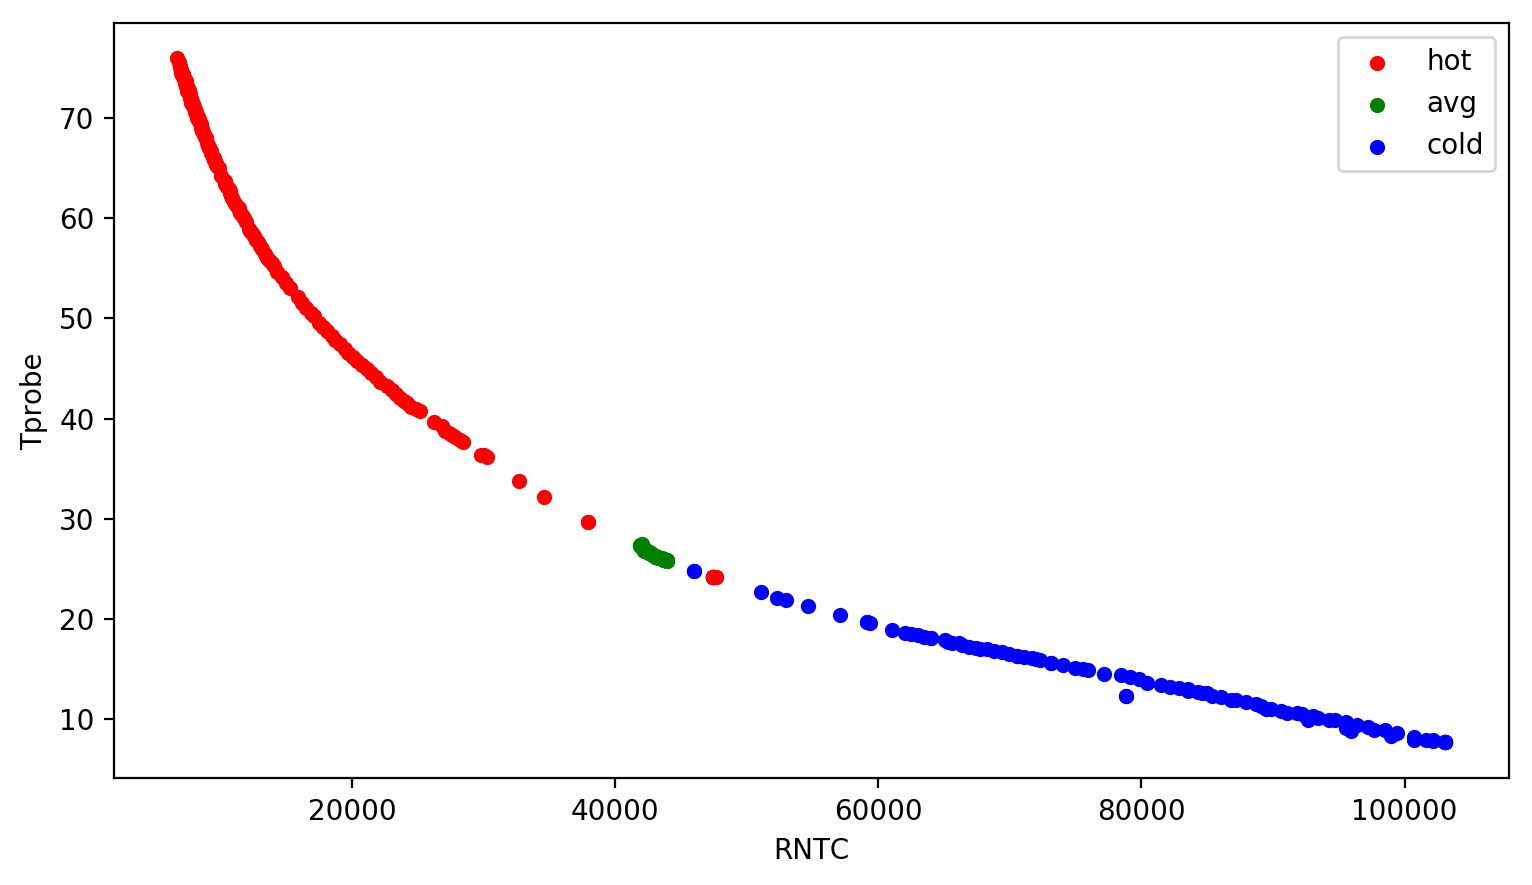

In [3]:
plt.rcParams['figure.dpi'] = 200
ax1 = df_hot.plot(kind='scatter', x='RNTC', y='Tprobe', figsize=(9, 5), c='r', label='hot')
df_avg.plot(kind='scatter', x='RNTC', y='Tprobe', c='g', ax=ax1, label='avg')
df_cold.plot(kind='scatter', x='RNTC', y='Tprobe', c='b', ax=ax1, label='cold')

## 2. Define The prediction intervals

In [4]:
##################################
#       Hyperparameters
##################################
precision_adc = 10
min_temp = 10   # the  minimum temperature we will predict
max_temp = 70   # the maximum temperature we will predict

# The temperature of the coefficients we will use to predict
feed_t1 = 11
feed_t2 = 27
feed_t3 = 54

fluctuation = 0.3

In [5]:
min_query = " Tprobe < " + str(feed_t1) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t1) + " - " + str(fluctuation)
avg_query = " Tprobe < " + str(feed_t2) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t2) + " - " + str(fluctuation)
max_query = " Tprobe < " + str(feed_t3) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t3) + " - " + str(fluctuation)

## Define the accuracy


### 1. Serial resistance

fetched from [this datasheet (page 111)](https://dam-assets.fluke.com/s3fs-public/45______umeng0400.pdf)

|**Bereik** | **Resolutie** | **Accuraatheid**|
|:--------:|:--------------:|:---------------:|
30 kΩ | 1Ω | 0.05% + 2
300kΩ | 10Ω | 0.05% + 2

In [6]:
# parameters from the fluke 45 datasheet (see table above)
accuracy = 0.05/100
offset = 2
resolution = 10

# measured resistance
serial_resistance = 47550

# calculate the error 
serial_resistance_error = round(serial_resistance * accuracy + offset, -math.floor(math.log10(resolution)))

r_const = Physical_Unit(RESISTANCE, OHM, serial_resistance, serial_resistance_error)
print(r_const)

(47550 ± 30.0) Ω


**Note**:
> To reduce the complexity, the temperature coefficient of the serial resisistance isn't taken into account

In [7]:
ADC_RANGE = 1023

def rntc2adc_err(rntc):
    return r_const * ADC_RANGE / (rntc + r_const)

def rntc2adc(rntc):
    return round(serial_resistance * ADC_RANGE / (rntc + serial_resistance), 0)

def adc2rntc_err(adc):
    return r_const * (-adc + ADC_RANGE) / adc

def adc2rntc(adc):
    return serial_resistance * (ADC_RANGE - adc) / adc

df['RNTC err'] = df.apply(lambda r: adc2rntc_err(rntc2adc_err(float(r.RNTC))).ae, axis=1)

### 2. ADC of microcontroller

In [8]:
# Retrieve some minimum NTC resistances 
RNTC_min, Tprobe_min = df_cold.loc[:, ['RNTC', 'Tprobe']].query(min_query).values[0]
RNTC_max, Tprobe_max = df_hot.loc[:, ['RNTC', 'Tprobe']].query(max_query).values[0]

In [9]:
adc_tmin = rntc2adc_err(float(RNTC_min))
adc_tmax = rntc2adc_err(float(RNTC_max))

print("Tmin: {}\tadc: {}".format(Tprobe_min, adc_tmin.to_scientific()))
print("Tmax: {}\tadc: {}".format(Tprobe_max, adc_tmax.to_scientific()))

Tmin: 10.75949	adc: 3.520E+2 ± 3E-1
Tmax: 54.095490000000005	adc: 7.82E+2 ± 9E-1


In [10]:
df.head()

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
0,0,45995.480769,24.788970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.038462
1,1,45995.480769,24.788970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.038462
2,2,78797.142857,12.281460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.428571
3,3,78797.142857,12.281460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.428571
4,4,95519.558824,9.088684,9.088684,-0.006903,0.001273,-0.000003,9.088684,95519.558824,12.28146,78797.142857,24.78897,45995.480769,180.529412


> Now, we will lineairly interpolate to determine the accuracy of the ADC

In [11]:
adc_accuracy = (max_temp - min_temp) / (adc_tmax - adc_tmin)
print(adc_accuracy)

(0.13953488372093023 ± 0.00037934600862986106) ^(-1)


### 3. Error on the probe temperature

>[this site](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=5884&pn=TSP01) only specifies the external probes accuracy @ 25°C, which is 0.5 °C. Therefore we will take the internal temperature sensor accuracy, this is 1.0°C. 

In [12]:
TSP01_error = 0.5

example_temp = Physical_Unit(TEMPERATURE, CELCIUS, 25, TSP01_error)
print(example_temp)

(25 ± 0.5) °C


## Query the min max and average temperature to calculate the coefficients

In [13]:
df.query(min_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
32,32,90642.1875,10.75949,9.738477,-0.005254,0.001048,-0.000002,7.64621,103049.535604,12.28146,78797.142857,24.78897,45995.480769,174.375


In [14]:
df.query(max_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
153,59,14654.15601,54.09549,54.09549,0.00092,0.000207,1.744787e-07,24.16681,47643.052838,29.62064,37939.718805,54.09549,14654.15601,78.491049


In [15]:
df.query(avg_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
277,18,41900.552486,27.23694,27.6842,-0.348956,0.049331,-0.000143,25.89944,43918.644068,27.6842,41900.552486,29.59512,40764.0,112.87136


In [16]:
R_NTC1, ERR_NTC1, T1 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(min_query).values[0]
R_NTC1 = Physical_Unit(RESISTANCE, OHM, R_NTC1, ERR_NTC1)
T1 = Physical_Unit(TEMPERATURE, CELCIUS, T1, TSP01_error)

R_NTC2, ERR_NTC2, T2 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(avg_query).values[0]
R_NTC2 = Physical_Unit(RESISTANCE, OHM, R_NTC2, ERR_NTC2)
T2 = Physical_Unit(TEMPERATURE, CELCIUS, T2, TSP01_error)

R_NTC3, ERR_NTC3, T3 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(max_query).values[0]
R_NTC3 = Physical_Unit(RESISTANCE, OHM, R_NTC3, ERR_NTC3)
T3 = Physical_Unit(TEMPERATURE, CELCIUS, T3, TSP01_error)

### Feed the temperature resistanca values to the steinhart equation

In [17]:
steinhart = SteinHart()
steinhart.feed(T=T1, R=R_NTC1)
steinhart.feed(T=T2, R=R_NTC2)
steinhart.feed(T=T3, R=R_NTC3)

In [18]:
def predT_err(r):
    return steinhart.calculateT(Physical_Unit(RESISTANCE, OHM, r.RNTC, r['RNTC err']))

df['T err'] = df.apply(lambda r: predT_err(r).ae, axis=1)
df['Tcalc 1'] = df.apply(lambda r: predT_err(r).val, axis=1)

df_pred = df # df.query('Tprobe >= ' + str(min_temp) + " and Tprobe  <= " + str(max_temp))
df_pred = df_pred.sort_values('RNTC')
df_pred.head()

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err,T err,Tcalc 1
273,179,6739.787946,76.02853,76.02853,0.000991,0.000197,2.035658e-07,24.16681,47643.052838,29.62064,37939.718805,76.02853,6739.787946,68.504464,3.878582,78.110699
272,178,6861.241611,75.65707,75.65707,0.000959,0.000201,1.904350e-07,24.16681,47643.052838,29.62064,37939.718805,75.65707,6861.241611,68.657718,3.814864,77.511326
270,176,6922.172452,75.07269,75.07269,0.001023,0.000192,2.170930e-07,24.16681,47643.052838,29.62064,37939.718805,75.07269,6922.172452,68.734602,3.783765,77.215502
271,177,6922.172452,75.16949,75.16949,0.001004,0.000195,2.090292e-07,24.16681,47643.052838,29.62064,37939.718805,75.16949,6922.172452,68.734602,3.783765,77.215502
264,170,6983.239910,74.66251,74.66251,0.001054,0.000188,2.298641e-07,24.16681,47643.052838,29.62064,37939.718805,74.66251,6983.239910,68.811659,3.753157,76.922195


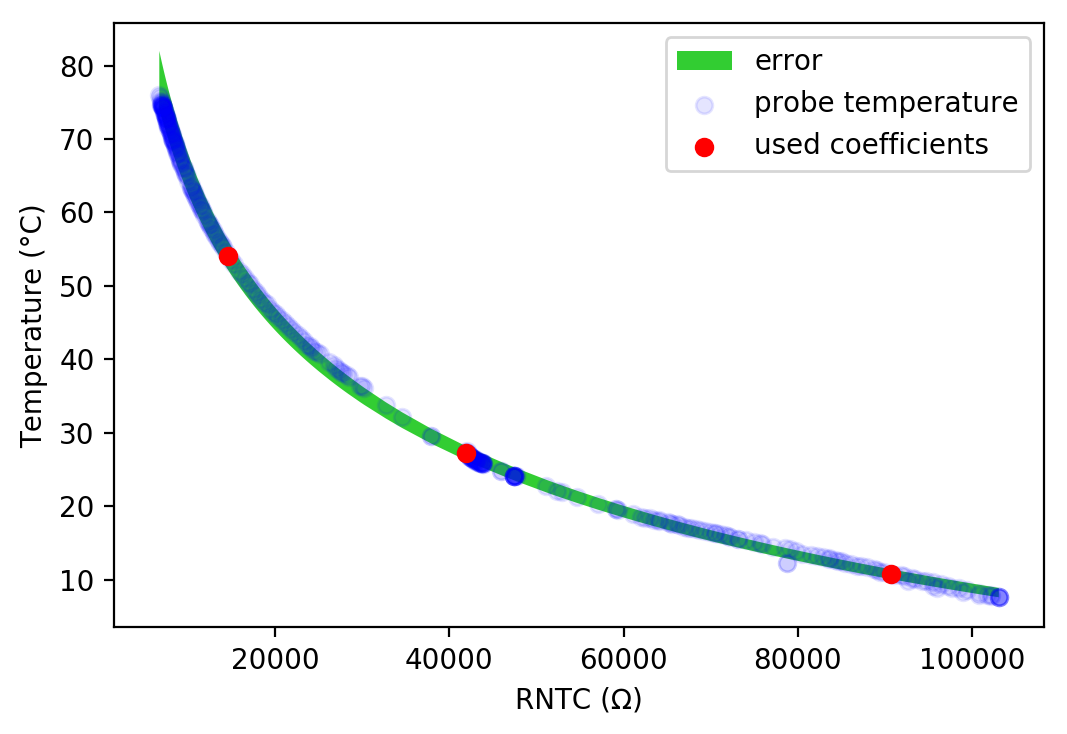

In [19]:
lower_bound = df_pred['Tcalc 1'].values - df_pred['T err'].values
upper_bound = df_pred['Tcalc 1'].values + df_pred['T err'].values

plt.fill_between(x=df_pred['RNTC'].values, y1=lower_bound, y2=upper_bound, facecolor='limegreen', interpolate=True, label='error')

plt.scatter(x=df_pred['RNTC'].values, y=df_pred['Tprobe'].values, c='b', alpha=.1, label='probe temperature')
plt.scatter(x=[R_NTC1.val, R_NTC2.val, R_NTC3.val], y = [T1.val, T2.val, T3.val], c='r', label='used coefficients')
plt.xlabel("RNTC (Ω)")
plt.ylabel("Temperature (°C)")
plt.legend()

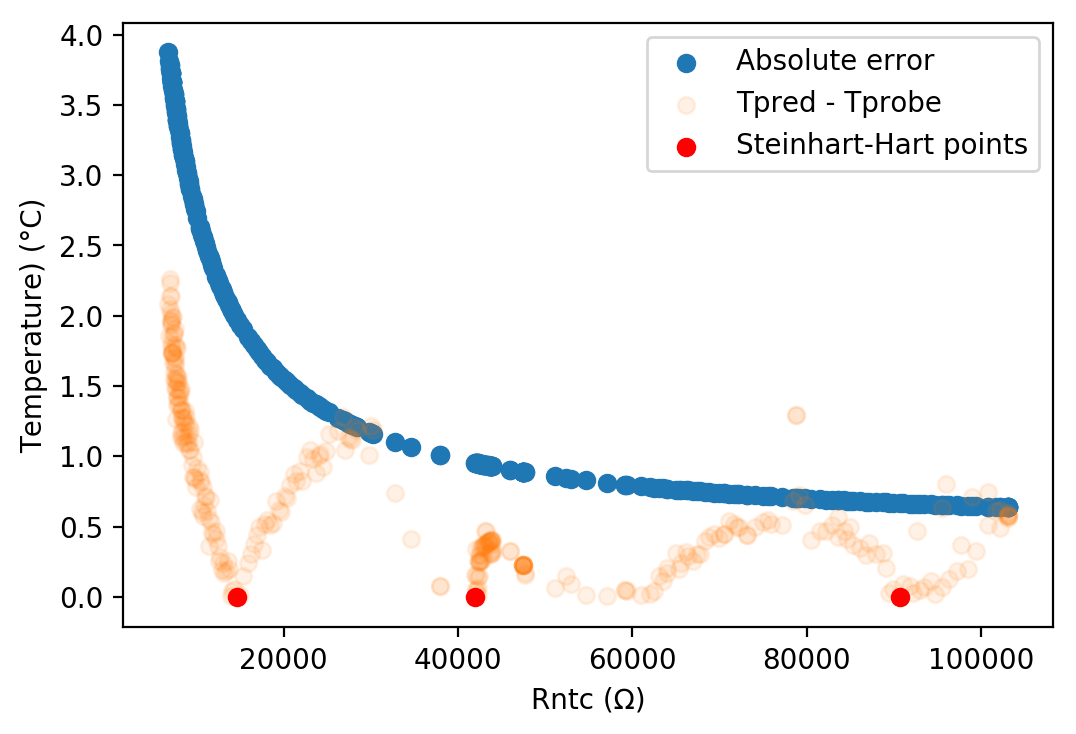

In [23]:
plt.scatter(x=df_pred['RNTC'], y=df_pred['T err'], label='Absolute error')
plt.scatter(x=df_pred['RNTC'], y=np.abs(df_pred['Tcalc 1'] - df_pred['Tprobe']), label='Tpred - Tprobe' , alpha=0.1)
plt.scatter(x=[R_NTC1.val, R_NTC2.val, R_NTC3.val], y = [0, 0, 0], c='r', label='Steinhart-Hart points')

plt.xlabel("Rntc (Ω)")
plt.ylabel("Temperature) (°C)")
plt.legend()

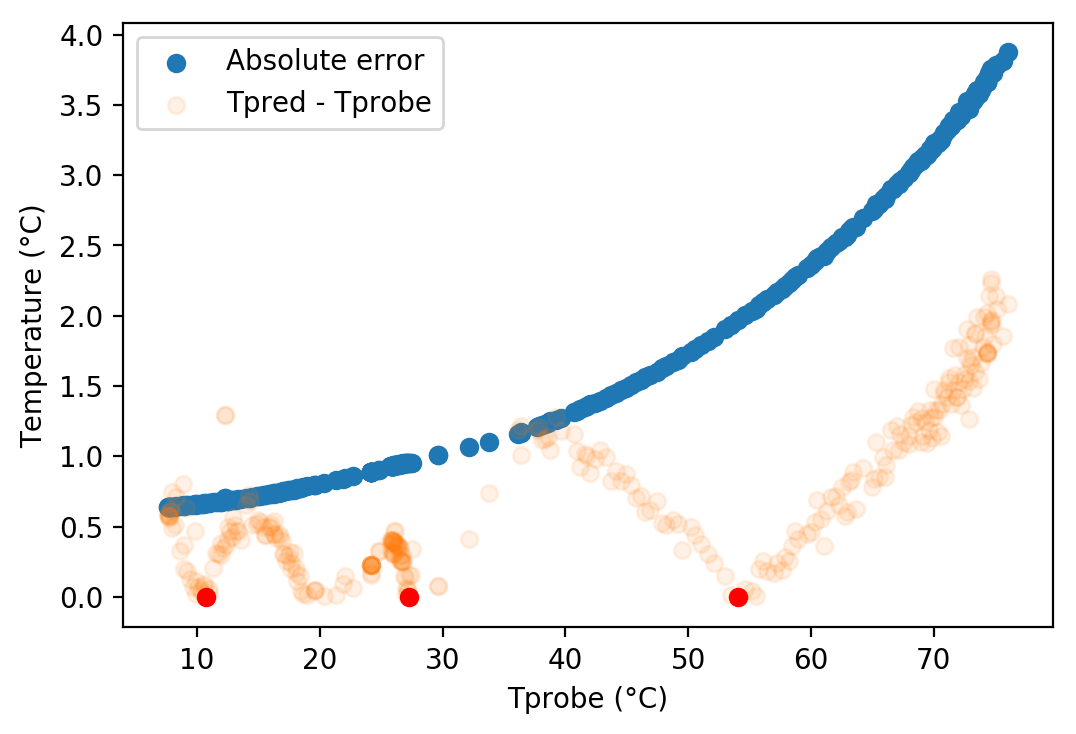

In [21]:
plt.scatter(x=df_pred['Tprobe'], y=df_pred['T err'], label='Absolute error')
plt.scatter(x=df_pred['Tprobe'], y=np.abs(df_pred['Tcalc 1'] - df_pred['Tprobe']), label='Tpred - Tprobe' , alpha=0.1)
plt.scatter(x=[T1.val, T2.val, T3.val], y = [0, 0, 0], c='r')

plt.xlabel("Tprobe (°C)")
plt.ylabel("Temperature (°C)")
plt.legend()

---